# Quality assessment Notebook for realism of quasars template.

To-do for this notebook:
    - modified the emission lines in SIMQSO.
    - compute the redshift and magnitude bins.
    - compute the EMPCA for mocks and BOSS DR14 data.
    - look the difference between mean continuum for mocks and data.
    - look the standard deviation for mocks and data from mean continuum.
    - look the difference between the first eigenvectors for mocks and data.
    - look at the difference between the dispersion of the first coefficients for mocks and data.
    - look the mean continuum from PICCA.
    - look 3d auto correlation of the Lya forest for old mock and the modified mocks.
Conclusion
    - Compare the mean continuum in the Lyman beta region from PICCA.
    - Compute the correlation function in the Lyman beta region.

# Import modules.

In [2]:
import numpy as np
import scipy as sp
import fitsio
import matplotlib.pyplot as plt
from desispec.interpolation import resample_flux
from desitarget.targetmask import desi_mask
import desispec.io
import sys
from collections import defaultdict
from astropy.io import fits
from astropy.table import Table,Column
from glob import glob

sys.path.append('/global/homes/r/rodcn25/PCA/empca/')
import empca
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# MOCKS.

Let me start by analysing the SIMQSO mocks from quickquasars. I produce 442,933 spectra with a exposure time of 4000 and take the mocks/lya_forest/london/v3.1, because these mocks have a Ly-$\beta$ forest.

SIMQSO use a table with 62 emission lines that goes from Ly-$\beta$ (1037.2 A) to HeI20580 (20506.8 A), I removed the three last lines and add three more lines Lyepsdel (940.93), CIII977 (985.46) and NIII991 (991.0).

The changes in SIMQSO are:
\begin{eqnarray}
('scaleEWs',&& \{'LyAb':1.1,'LyAn':1.1,\\
            && 'CIVb':0.75,'CIVn':0.75,\hspace{3cm}DEFAULT\\
            && 'CIII]b':0.8,'CIII]n':0.8,\\
            && 'MgIIb':0.8,'MgIIn':0.8\})
\end{eqnarray}

Change:
\begin{eqnarray}
('scaleEWs',&&\{'Lyepsdel':0.07,\\
            &&\{'CIII977':0.185,\\
            &&\{'NIII991':0.051,\\
            &&\{'LyB':1.22,\\
            && 'ArI':0.81,\\
            && 'FeIII:UV1':0.31,\\
            && 'CIII*':0.65,\\
            && 'LyAb':1.0,'LyAn':1.0,\\
            && 'NV':2.2,\\
            && 'SiII':0.9,\\
            && 'OI':1.5,\\
            && 'CII':0.45,\\
            && 'SiIV+OIV]':0.92,\\
            && 'CIVb':0.75,'CIVn':0.75,\\
            && 'CIII]b':1.2,'CIII]n':1.3,\\
            && 'MgIIb':1.7,'MgIIn':1.7\})
\end{eqnarray}

Maybe NV must be changed, because here there is a effect of the metals.

In [3]:
### Get mocks
mock = {}
mock['base'] = '/global/cscratch1/sd/rodcn25/lya/'
mocks_file = mock['base']+'quick-runs/test_com/quick-simqso-test-0.7/'
print(mocks_file)
specfile = sorted(glob(mocks_file+'spectra-16/*/*/spectra*.fits')) # Read all files spectra.fits 

/global/cscratch1/sd/rodcn25/lya/quick-runs/test_com/quick-simqso-test-0.7/


In [4]:
mflux = []
mivar = []
mwavebrf = []
mwaverrf = []
mwavezrf = []
for i in range(len(specfile)): #Loop for read all pixel. [:1] mean that read only the first.
    specfilename = specfile[i] #choose a pixel to be read.
    specobj= desispec.io.read_spectra(specfilename)
    DM = fitsio.FITS(specfilename)
    MAG_G = 22.5 - 2.5*np.log10(DM[1]['FLUX_G'].read())
    zfilename = specfilename.replace('spectra-16-', 'zbest-16-') 
    zs = fitsio.read(zfilename) # zbest file.
    qsoivars = []
    qsofluxs = []
    b_rf = []
    r_rf = []
    z_rf = []
    for j in range(len(MAG_G)):
        if 20.0 < MAG_G[j] < 20.5:
            if 2.4 < zs['Z'][j] < 2.6:
                ### Put spectra in the rest-frame
                wavem = specobj.wave
                fluxm = specobj.flux
                z = zs['Z'][j]
                brf = wavem['b']/(1+z)
                rrf = wavem['r']/(1+z)
                zrf = wavem['z']/(1+z)
                
                ### remove the colorcut
                ivarm = specobj.ivar
                qsoflux = []
                qsoivar = []
                for m in range(len(brf)):
                    qsoflux.append(fluxm['b'][j][m])
                    qsoivar.append(ivarm['b'][j][m])
                for n in range(len(rrf)):
                    if rrf[n]>np.max(brf):
                        qsoflux.append(fluxm['r'][j][n])
                        qsoivar.append(ivarm['r'][j][n])
                for o in range(len(zrf)):
                    if zrf[o]>np.max(rrf):
                        qsoflux.append(fluxm['z'][j][o])
                        qsoivar.append(ivarm['z'][j][o])
                qsofluxs.append(qsoflux)
                qsoivars.append(qsoivar)
                b_rf.append(brf)
                r_rf.append(rrf)
                z_rf.append(zrf)
                
    mflux.append(qsofluxs)
    mivar.append(qsofluxs)
    mwavebrf.append(b_rf)
    mwaverrf.append(r_rf)
    mwavezrf.append(z_rf)

### remove the pixels with cero spectra.
mwavebrff = []
mwaverrff = []
mwavezrff = []
mmflux = []
mmivar = []
for b in range(len(mwavebrf)):
    if len(mwavebrf[b])==0:
        continue
    if len(mflux[b])==0:
        continue
    if len(mivar[b])==0:
        continue
    else:
        mwavebrff.append(mwavebrf[b])
        mwaverrff.append(mwaverrf[b])
        mwavezrff.append(mwavezrf[b])
        mmflux.append(mflux[b])
        mmivar.append(mivar[b])
        
b_r_f = np.vstack(mwavebrff)
r_r_f = np.vstack(mwaverrff)
z_r_f = np.vstack(mwavezrff)

###stack wavelenghts
waves = []
for i in range(len(b_r_f)):
    dw = b_r_f[i][1]-b_r_f[i][0]
    new_wave = np.arange(np.min(b_r_f[i]),np.max(z_r_f[i]),dw)
    waves.append(new_wave)
##########
wavelength = np.vstack(waves)
qsofluxss = np.vstack(mmflux)
qsoivarss = np.vstack(mmivar)

In [5]:
print(qsofluxss.shape, 'Shape of the flux')
# new wavelenght for compute EMPCA.
CRVAL1 = 2.6534
CDELT1 = 0.0001
NBLL   = 13637
wwave = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)

(5261, 6265) Shape of the flux


### EMPCA for mocks.

In [6]:
pcafluxm  = sp.zeros((len(qsofluxss), wwave.size))
pcaivarm  = sp.zeros((len(qsofluxss), wwave.size))

for i in range(len(qsofluxss)):
    pcafluxm[i], pcaivarm[i] = resample_flux(wwave,wavelength[i],qsofluxss[i],qsoivarss[i]) # interpolation
    
pcaivarm[pcaivarm<0.] = 0              #
w = sp.sum(pcaivarm,axis=0)>0.         #
wwave = wwave[w]                       # For the noise.
pcafluxm = pcafluxm[:,w]               #
pcaivarm = pcaivarm[:,w]               #
pcaivarm[pcaivarm>100.] = 100.         #

Before compute EMPCA, we need to calculate the mean spectrum and subtract it of the spectra, such that the eigenvectors represent the principal variations of the spectra with respect to that mean spectrum.

In [7]:
mock_mean_spec = sp.average(pcafluxm,weights=pcaivarm,axis=0)
for i in range(len(qsofluxss)):       #
    w = pcaivarm[i]>0.        # subtracting the mean for each spectrum
    pcafluxm[i,w] -= mock_mean_spec[w]

Here start the EMPCA decomposition with 10 principal components.

In [8]:
mmodel = empca.empca(pcafluxm, weights=pcaivarm, niter=10, nvec=10)

       iter        R2             rchi2
EMPCA  1/10       0.00317890      3.30799128
EMPCA  2/10       0.01573143      2.96423842
EMPCA  3/10       0.03638267      1.04702587
EMPCA  4/10       0.03940983      0.73373343
EMPCA  5/10       0.03963880      0.70473657
EMPCA  6/10       0.03936708      0.72808709
EMPCA  7/10       0.03928991      0.73667472
EMPCA  8/10       0.03962349      0.70681670
EMPCA  9/10       0.03993242      0.67947585
EMPCA 10/10       0.04008040      0.66685017
R2: 0.0401483633481


The results are saved in .fits files.

# BOSS DR14 data.

Define Lyman series

In [9]:
# Lyman-alpha from eqn 5 of Calura et al. 2012 (Arxiv: 1201.5121)
# Other from eqn 1.1 of Irsic et al. 2013 , (Arxiv: 1307.3403)
# Lyman-limit from abstract of Worseck et al. 2014 (Arxiv: 1402.4154)
Lyman_series = {
    'Lya'     : { 'line':1215.67,  'A':0.0023,          'B':3.64, 'var_evol':3.8 },
    'Lyb'     : { 'line':1025.72,  'A':0.0023/5.2615,   'B':3.64, 'var_evol':3.8 },
    'Ly3'     : { 'line':972.537,  'A':0.0023/14.356,   'B':3.64, 'var_evol':3.8 },
    'Ly4'     : { 'line':949.7431, 'A':0.0023/29.85984, 'B':3.64, 'var_evol':3.8 },
    'Ly5'     : { 'line':937.8035, 'A':0.0023/53.36202, 'B':3.64, 'var_evol':3.8 },
    #'LyLimit' : { 'line':911.8,    'A':0.0023,          'B':3.64, 'var_evol':3.8 },
}

Transmitted flux fraction from Lyman series.

In [10]:
def transmission_Lyman(zObj,lObs):
    '''Calculate the transmitted flux fraction from the Lyman series
    This returns the transmitted flux fraction:
        1 -> everything is transmitted (medium is transparent)
        0 -> nothing is transmitted (medium is opaque)
    Args:
        zObj (float): Redshift of object
        lObs (array of float): wavelength grid
    Returns:
        array of float: transmitted flux fraction
    '''

    lRF = lObs/(1.+zObj)
    T   = sp.ones(lObs.size)

    for l in list(Lyman_series.keys()):
        w      = lRF<Lyman_series[l]['line']
        zpix   = lObs[w]/Lyman_series[l]['line']-1.
        tauEff = Lyman_series[l]['A']*(1.+zpix)**Lyman_series[l]['B']
        T[w]  *= sp.exp(-tauEff)

    return T

let's remove the sky lines.

In [11]:
def lines_list(path):

    lines = []
    fileLines = open(path)
    for l in fileLines:
        l = l.split()
        if l[0]=='#': continue
        lines += [ [float(l[1]),float(l[2])] ]
    fileLines.close()
    lines = sp.asarray(lines)

    return lines

let's remove galactic extinction.

In [12]:
def unred(wave, ebv, R_V=3.1, LMC2=False, AVGLMC=False):
    '''
    https://github.com/sczesla/PyAstronomy
    in /src/pyasl/asl/unred
    '''

    x = 10000./wave # Convert to inverse microns
    curve = x*0.

    # Set some standard values:
    x0 = 4.596
    gamma = 0.99
    c3 = 3.23
    c4 = 0.41
    c2 = -0.824 + 4.717/R_V
    c1 = 2.030 - 3.007*c2

    if LMC2:
        x0    =  4.626
        gamma =  1.05
        c4   =  0.42
        c3    =  1.92
        c2    = 1.31
        c1    =  -2.16
    elif AVGLMC:
        x0 = 4.596
        gamma = 0.91
        c4   =  0.64
        c3    =  2.73
        c2    = 1.11
        c1    =  -1.28

    # Compute UV portion of A(lambda)/E(B-V) curve using FM fitting function and
    # R-dependent coefficients
    xcutuv = sp.array([10000.0/2700.0])
    xspluv = 10000.0/sp.array([2700.0,2600.0])

    iuv = sp.where(x >= xcutuv)[0]
    N_UV = iuv.size
    iopir = sp.where(x < xcutuv)[0]
    Nopir = iopir.size
    if N_UV>0:
        xuv = sp.concatenate((xspluv,x[iuv]))
    else:
        xuv = xspluv

    yuv = c1 + c2*xuv
    yuv = yuv + c3*xuv**2/((xuv**2-x0**2)**2 +(xuv*gamma)**2)
    yuv = yuv + c4*(0.5392*(sp.maximum(xuv,5.9)-5.9)**2+0.05644*(sp.maximum(xuv,5.9)-5.9)**3)
    yuv = yuv + R_V
    yspluv = yuv[0:2]  # save spline points

    if N_UV>0:
        curve[iuv] = yuv[2::] # remove spline points

    # Compute optical portion of A(lambda)/E(B-V) curve
    # using cubic spline anchored in UV, optical, and IR
    xsplopir = sp.concatenate(([0],10000.0/sp.array([26500.0,12200.0,6000.0,5470.0,4670.0,4110.0])))
    ysplir = sp.array([0.0,0.26469,0.82925])*R_V/3.1
    ysplop = sp.array((sp.polyval([-4.22809e-01, 1.00270, 2.13572e-04][::-1],R_V ),
            sp.polyval([-5.13540e-02, 1.00216, -7.35778e-05][::-1],R_V ),
            sp.polyval([ 7.00127e-01, 1.00184, -3.32598e-05][::-1],R_V ),
            sp.polyval([ 1.19456, 1.01707, -5.46959e-03, 7.97809e-04, -4.45636e-05][::-1],R_V ) ))
    ysplopir = sp.concatenate((ysplir,ysplop))

    if Nopir>0:
      tck = interpolate.splrep(sp.concatenate((xsplopir,xspluv)),sp.concatenate((ysplopir,yspluv)),s=0)
      curve[iopir] = interpolate.splev(x[iopir], tck)

    #Now apply extinction correction to input flux vector
    curve *= ebv
    corr = 1./(10.**(0.4*curve))

    return corr

Let's read the data and only choose the quasars. 

In [13]:
def plot_spplate(path_to_data,plate,mjd,fiber):

    ###
    path = path_to_data+str(plate)+'/spPlate-' +str(plate)+'-'+str(mjd)+'.fits'

    cat = fitsio.FITS(path)
    psflux = cat[0].read()
    psivar = cat[1].read()
    end  = cat[2].read()
    h    = cat[4].read_header()
    fid = cat[5].read()
    cat.close()

    pswave = h['CRVAL1'] + h['CD1_1']*sp.arange(h['NAXIS1'])
    if h['DC-FLAG']:
        pswave = 10**pswave

    ###
    cut = (psivar[fiber-1,:]>0.) & (end[fiber-1,:]==0)
    qsoid = np.where(fid['OBJTYPE'][:] == b'QSO             ')[0]#I only choose the QSO's. 
    if (fiber-1) in qsoid:
        pswave = pswave[cut]
        psflux = psflux[fiber-1,:][cut]
        psivar = psivar[fiber-1,:][cut]
    else: 
        #print('No QSO')
        pswave = np.array([0])
        psflux = np.array([0])
        psivar = np.array([0])

    return pswave, psflux, psivar

The next cell is only to represent the procedure to obtain the EMPCA decompposition. The results of the bins are saved in .fits file.

``` python
def get_pca():

    ### Parameters
    path_spec      = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
    path_drq       = '/global/cscratch1/sd/rodcn25/lya/boss_data/DR14Q_v4_4.fits'
    path_lines     = '/global/homes/r/rodcn25/PCA/dr14-line-sky-mask.txt'
    nbObj  = 10000
    CRVAL1 = 2.6534
    CDELT1 = 0.0001
    NBLL   = 13637

    ### Get lines to veto
    lines = lines_list(path_lines)

    ### Get list qso
    data      = fitsio.FITS(path_drq)
    w  = sp.ones(data[1]['PLATE'][:].size).astype(bool)
    print('INFO: init              : ', w.sum())
    w &= data[1]['THING_ID'][:]>0.
    print('INFO: removed THID>=0   : ', w.sum())
    #print('INFO: removed THID<=0   : ', w.sum())
    w &= data[1]['Z_PCA'][:]>0.
    print('INFO: removed zvi>=0.   : ', w.sum())
    #print('INFO: removed zvi<=0.   : ', w.sum())
    plate   = data[1]['PLATE'][:][w]
    mjd     = data[1]['MJD'][:][w]
    fiberid = data[1]['FIBERID'][:][w]
    zvi     = data[1]['Z_PCA'][:][w]
    AMag_g  = data[1]['PSFMAG'][:][:,1][w]  
    rvextinction=3.793
    G_EXTINCTION = data[1]['GAL_EXT'][:][:,1]/rvextinction # Galactic extinction for the g band.
    extg = G_EXTINCTION[w]
    data.close()
    nsamples=31200
    ### Random number of object
    sp.random.seed(10)
    listQSO = sp.arange(plate.size)
    randSelec = sp.array([])
    for i in sp.arange(0.,10.,0.1):
        w = (zvi>=i) & (zvi<i+0.1)
        if listQSO[w].size==0: continue
        r = sp.random.choice(listQSO[w], size=min(listQSO[w].size,nsamples), replace=False)
        randSelec = sp.append(randSelec,r)
    #randSelec = sp.append(randSelec,sp.random.choice(listQSO, size=nbObj, replace=False))
    randSelec = sp.unique(randSelec)
    randSelec = randSelec.astype(int)
    nbObj = randSelec.size
    print('INFO: size = ', nbObj)


    ### Get spectra
    ttwave = []
    ttflux = []
    ttivar = []
    for i in range(nbObj): 
        #if i%10==0: print(i)
        r = randSelec[i]
        
        if 21.5<AMag_g[r]<22.0:  # Magnitude bin
            if 2.4<zvi[r]<2.6:   #redshift bin
                TMPwave, TMPflux, TMPivar = plot_spplate(path_spec,plate=plate[r],mjd=mjd[r],fiber=fiberid[r])
                TMPwaveRF = TMPwave/(1.+zvi[r])
                if TMPwave.size<500:
                    #print('INFO: removing size<10: {}'.format(TMPwave.size))
                    continue        
                ### Remove sky lines and CCD edge
                w = sp.ones_like(TMPwave).astype(bool)
                for l in lines:
                    w &= (TMPwave<l[0]) | (TMPwave>l[1])
                w &= TMPwave>3600.
                w &= TMPwave<7235.
                TMPwave = TMPwave[w]
                TMPflux = TMPflux[w]
                TMPivar = TMPivar[w]
                TMPwaveRF = TMPwaveRF[w]
                if TMPwave.size<500:
                    #print('INFO: removing size<10: {}'.format(TMPwave.size))
                    continue
                    
                ### Correct for Lyman
                T = transmission_Lyman(zvi[r],TMPwave)
                TMPflux /= T
                TMPivar *= T**2
                ### Remove Galactic extinction for g, r and z bands
                tunred_g = unred(TMPwave,extg[r])
                TMPflux /= tunred_g
                TMPivar *= tunred_g**2
                ### Store
                ttwave += [TMPwaveRF]
                ttflux += [TMPflux]
                ttivar += [TMPivar]
            else:
                continue
        else:
            continue
        
    rwave = []
    rflux = []
    rivar = []
    for j in range(len(ttflux)):
        if ttwave[j].any() and ttflux[j].any() == False:
            continue
        elif ttwave[j].any() and ttflux[j].any() == True:
            rwave += [ttwave[j]]
            rflux += [ttflux[j]]
            rivar += [ttivar[j]]
            
    rrwave = []
    rrflux = []
    rrivar = []
    for k in range(len(rflux)):
        wl = rwave[k]
        fl = rflux[k]
        iv = rivar[k]
        maskk = (wl>1250.0) & (wl<1500.0)
        if fl[maskk].any() == 0. :
            continue
        else:
            rrwave += [wl]
            rrflux += [fl]
            rrivar += [iv]

    nbObj = len(rrwave)
    print('INFO: size = ', nbObj)

    ###
    pcawave    = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)
    pcaflux    = sp.zeros((nbObj, pcawave.size))
    pcaivar    = sp.zeros((nbObj, pcawave.size))
    ### On same grid
    for i in range(nbObj):
        pcaflux[i],pcaivar[i] = resample_flux(pcawave, rrwave[i], rrflux[i], rrivar[i])
    pcaivar[pcaivar<0.] = 0.
    ### Remove if all measured bins are zero
    w    = sp.sum(pcaivar,axis=0)>0.
    pcawave = pcawave[w]
    pcaflux = pcaflux[:,w]
    pcaivar = pcaivar[:,w]
    ### Cap the ivar
    pcaivar[pcaivar>100.] = 100.

    ### Get the mean
    data_meanspec = sp.average(pcaflux,weights=pcaivar,axis=0) # Here, I get the mean spectrum.
    for i in range(nbObj):       #
        w = pcaivar[i]>0.        # subtracting the mean for each spectrum
        pcaflux[i,w] -= data_meanspec[w] #

    ### PCA
    print('INFO: Starting EMPCA')
    dmodel = empca.empca(pcaflux, weights=pcaivar, niter=10, nvec=10)
        
    return dmodel, pcawave, pcaflux, pcaivar, data_meanspec
```

Then, let's load the .fits file for mocks and data.

In [14]:
### Mocks
specfile11 = mock['base']+'pruebas_simqso/fits file/qa_bins/mock_magv1_zv1.fits'
specfile22 = mock['base']+'pruebas_simqso/fits file/qa_bins/mock_magv2_zv2.fits'
specfile33 = mock['base']+'pruebas_simqso/fits file/qa_bins/mock_magv3_zv3.fits'
specfile24 = mock['base']+'pruebas_simqso/fits file/qa_bins/mock_magv2_zv4.fits'
MG11 = fitsio.FITS(specfile11)
MG22 = fitsio.FITS(specfile22)
MG33 = fitsio.FITS(specfile33)
MG24 = fitsio.FITS(specfile24)

In [15]:
### BOSS DR14 data.
fdata11 = mock['base']+'pruebas_simqso/fits file/qa_bins/d14_magv1_zv1.fits'
fdata22 = mock['base']+'pruebas_simqso/fits file/qa_bins/d14_magv2_zv2.fits'
fdata33 = mock['base']+'pruebas_simqso/fits file/qa_bins/d14_magv3_zv3.fits'
fdata24 = mock['base']+'pruebas_simqso/fits file/qa_bins/dr14_magv2_z4.fits'
DS11 = fitsio.FITS(fdata11)
DS22 = fitsio.FITS(fdata22)
DS33 = fitsio.FITS(fdata33)
DS24 = fitsio.FITS(fdata24)

### Let me define a some functions 

Let's get the first four eigenvector for reconstruct the MOCKS continuum spectra.
\begin{equation} 
      y(\lambda) = \mu(\lambda) + \sum_{k=1}^{4}c_{k}\phi_{k}(\lambda),
\end{equation}
where $\mu$ is the mean spectrum, $c_{k}$ the coefficients and $\phi_{k}$ are the eigenvectors.

Let me normalize the spectra as follows. 
\begin{equation}
     \int_{1280}^{1500}F(\lambda) d\lambda = 1.
\end{equation}

Let's obtain the mean continuum and the standard deviation. 

In [16]:
def empca_nor_stack(wavelength,coeff,eigvec,mean_spec,n_vec=4,lmin=1280.0,lmax=1500.0,dw = 0.28):
    ### Choose the first four eigenvectors
    conti_mock = []
    for i in range(len(coeff)):
        spectram = []
        for j in range(n_vec):
            spectram.append(coeff[i][j]*eigvec[j])
        spectrasm = np.vstack(spectram)
        specm = np.sum(spectrasm,axis = 0)
        conti_mock += [specm]
    continuum_mock = np.vstack(conti_mock)
    ###
    new_wave = np.arange(600, 3000, dw)
    flux_mock = np.zeros((len(continuum_mock), new_wave.size))
    for i in range(len(continuum_mock)):
        flux_mock[i] = resample_flux(new_wave, wavelength, mean_spec+continuum_mock[i])
    ### Normalization
    integral_mock = []
    continuum_nor_mock = []
    for i in range(len(flux_mock)):
        sum2=0
        for j in range(len(flux_mock[i])):
            if lmin <= new_wave[j] < lmax :
                sum2+=(flux_mock[i][j])*(new_wave[j+1]-new_wave[j])
            elif (new_wave[j] > lmax):
                break
        integral_mock.append(sum2)
        continuum_nor_mock.append(flux_mock[i]/sum2)
    contin_mock = np.vstack(continuum_nor_mock)
    ### Normalization for the eigenvalues.
    coefficient = np.zeros((4,len(coeff)))
    for k in range(4):
        coefficient[k] = coeff[:,k]/integral_mock
    ### Stack
    stack_mock = np.mean(contin_mock,axis=0)     # mean continuum.
    std_stack_mock = np.std(contin_mock,axis=0)  # standard deviation.
    return new_wave, stack_mock, std_stack_mock, coefficient

Let's compare the mean continuum between mocks and data.

In [17]:
def mean_cont(mwave,mflux,dwave,dflux,stdm,stdd,zmin,zmax,magmin,magmax,xmin,xmax,xminzoom,xmaxzoom):
    plt.figure(figsize=(14,15))
    plt.subplot(2,1,1)
    plt.title('Mean Continuum     {} < MAG < {} and {} < z < {}.'.format(magmin,magmax,zmin,zmax),fontsize = 20)
    plt.plot(dwave,dflux,'-', label='Stack DR14',alpha=0.7)
    #plt.fill_between(new_wave,stack_boss+std_stack_boss,stack_boss-std_stack_boss, label='std BOSS', color = 'y', alpha=0.5)
    plt.plot(mwave,mflux,'-', label='Stack MOCK',alpha=0.7)
    #plt.fill_between(new_wave,stack_mock+std_stack_mock,stack_mock-std_stack_mock, label='std MOCK', color = 'k', alpha=0.4)
    plt.xlim(xmin,xmax)
    #plt.ylim(-0.002,0.01)
    #axvline(940.93)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
    plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
    plt.legend(fontsize='xx-large')
    plt.grid()
    
    mask = (dwave>900) & (dwave<1216)

    plt.subplot(2,1,2)
    plt.plot(dwave[mask],dflux[mask], label='Stack DR14')
    plt.fill_between(dwave[mask],dflux[mask]+stdd[mask],dflux[mask]-stdd[mask], label='std BOSS', color = 'y', alpha=0.5)
    plt.plot(mwave[mask],mflux[mask], label='Stack MOCK')
    plt.fill_between(mwave[mask],mflux[mask]+stdm[mask],mflux[mask]-stdm[mask], label='std MOCK', color = 'k', alpha=0.4)
    plt.xlim(xminzoom,xmaxzoom)
    plt.ylim(0,0.04)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
    plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
    plt.legend(fontsize='xx-large')
    plt.grid()

Let's compare the first four principal components between mocks and data.

In [18]:
def eigvec_plot(mmwave,mmeigvec,ddwave,ddeigvec,xxmin,xxmax):
    plt.figure(figsize=(14,30))
    for i in range(4):
        plt.subplot(4,1,i+1)
        plt.title('Principal Component {}'.format(i+1),fontsize=20)
        plt.plot(ddwave,ddeigvec[i],label='BOSS')
        plt.plot(mmwave,mmeigvec[i],label='MOCK')
        plt.xlim(xxmin,xxmax)
        #plt.ylim(-2,10)
        plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
        plt.ylabel('Flux', fontsize = 20)
        #plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
        plt.legend(fontsize='xx-large')
        plt.grid()

Let's compare the dispersion of the first coefficients for mocks and data.

In [31]:
def coeff_hist(mcoeff,dcoeff,cmin,cmax,sizebin):
    plt.figure(figsize=(26,5))
    plt.title('Distributions of the coefficient',fontsize=20)
    for i in range(len(mcoeff)):
        plt.subplot(1,4,i+1)
        mweights11=np.ones_like(mcoeff[i])/len(mcoeff[i])
        dweights11=np.ones_like(dcoeff[i])/len(dcoeff[i])
        n = (cmax-cmin)/sizebin
        eig0bin = np.linspace(cmin,cmax, n+1)
        ll, mm, nn = plt.hist(dcoeff[i],eig0bin,histtype='step',weights=dweights11,label='BOSS')
        ii, jj, kk = plt.hist(mcoeff[i],eig0bin,histtype='step',weights=mweights11,label='MOCK')
        ax = plt.gca()
        plt.text(0.1, 0.9, 'eigvec {}'.format(i+1),transform=ax.transAxes,fontsize = 15)
        plt.xlabel('$c_{k}$', fontsize = 20)
        plt.ylabel('Frequency', fontsize = 20)
        plt.legend(fontsize='xx-large')

# 20.0 < MAG < 20.5 and 2.4 < z < 2.6.

In [20]:
### mocks
wave11, mean11, std11, coeff11 = empca_nor_stack(MG11[1]['wavelength'].read(),MG11[4]['coeff'].read(),MG11[3]['eigenvec'].read(),MG11[1]['mean spectrum'].read())

In [21]:
### data
dwave11, dmean11, dstd11, dcoeff11 = empca_nor_stack(DS11[1]['wavelength'].read(),DS11[4]['coeff'].read(),DS11[3]['eigenvec'].read(),DS11[1]['mean spectrum'].read())

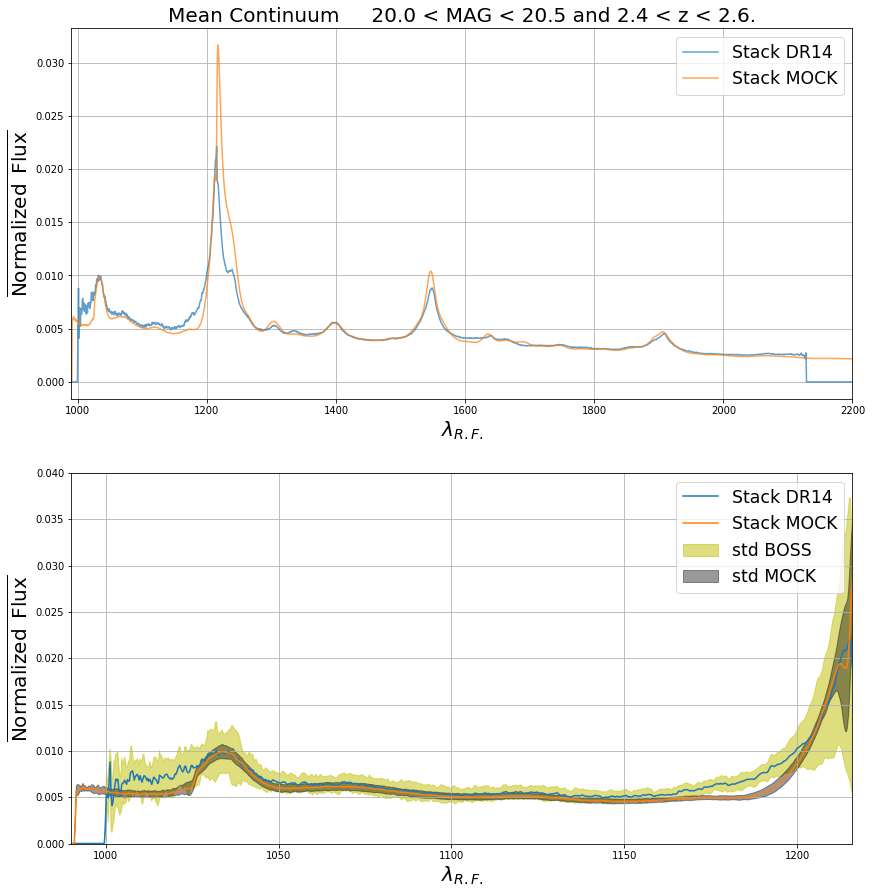

In [22]:
mean_cont(wave11,mean11,dwave11,dmean11,std11,dstd11,2.4,2.6,20.0,20.5,990,2200,990,1216)
#plt.savefig('mean_cont_11.png')

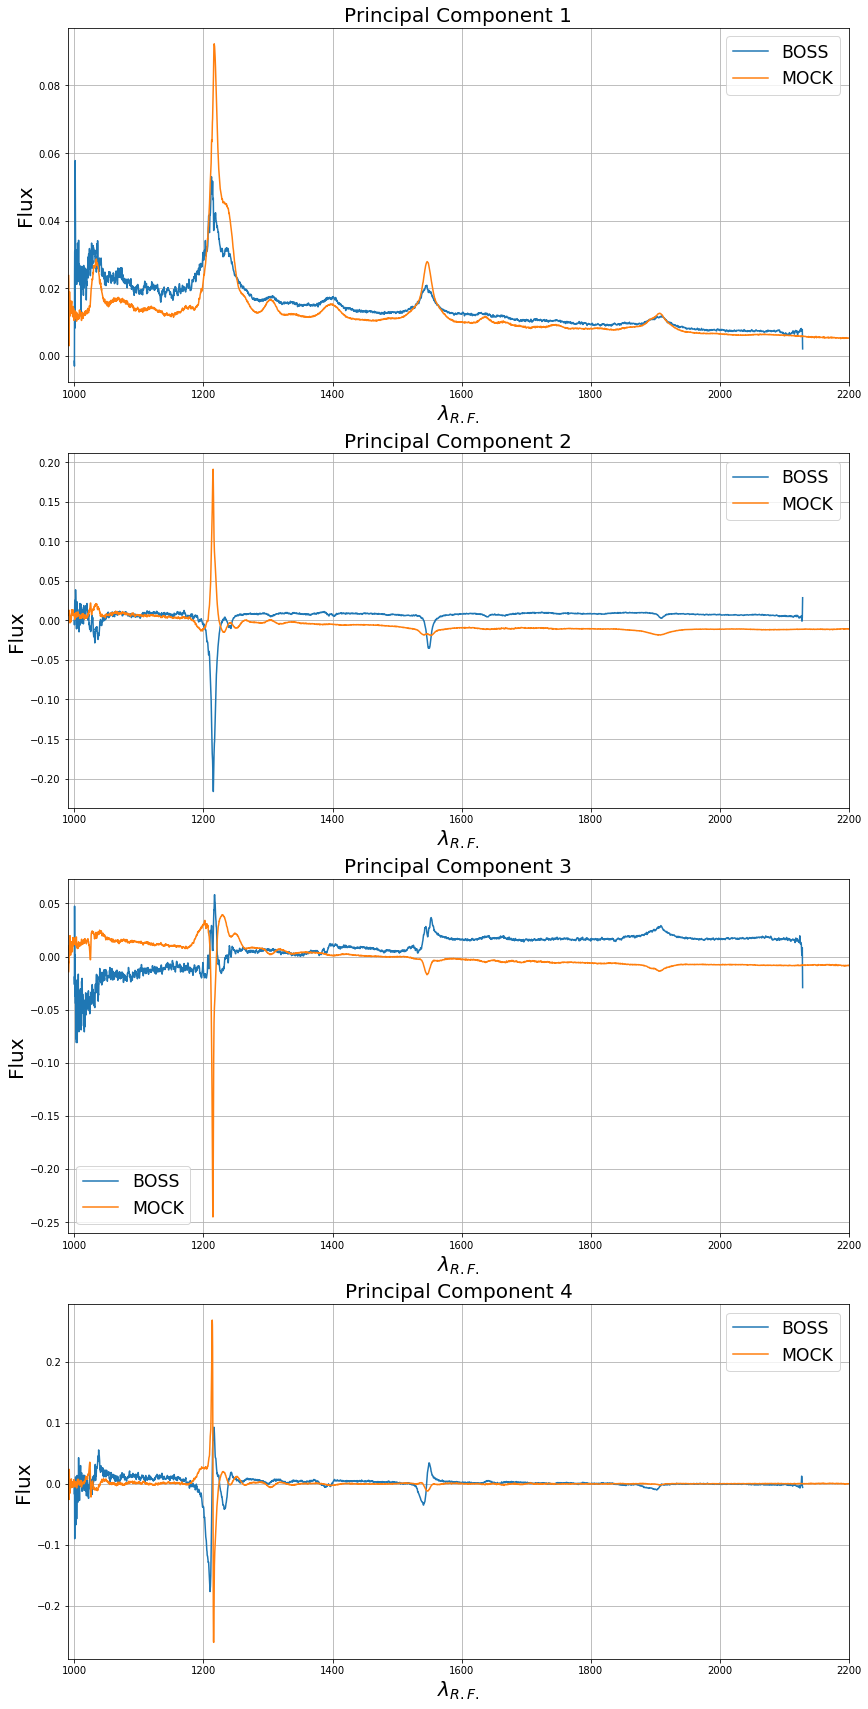

In [23]:
eigvec_plot(MG11[1]['wavelength'].read(),MG11[3]['eigenvec'].read(),DS11[1]['wavelength'].read(),DS11[3]['eigenvec'].read(),990,2200)
#plt.savefig('eigvecs_11.png')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


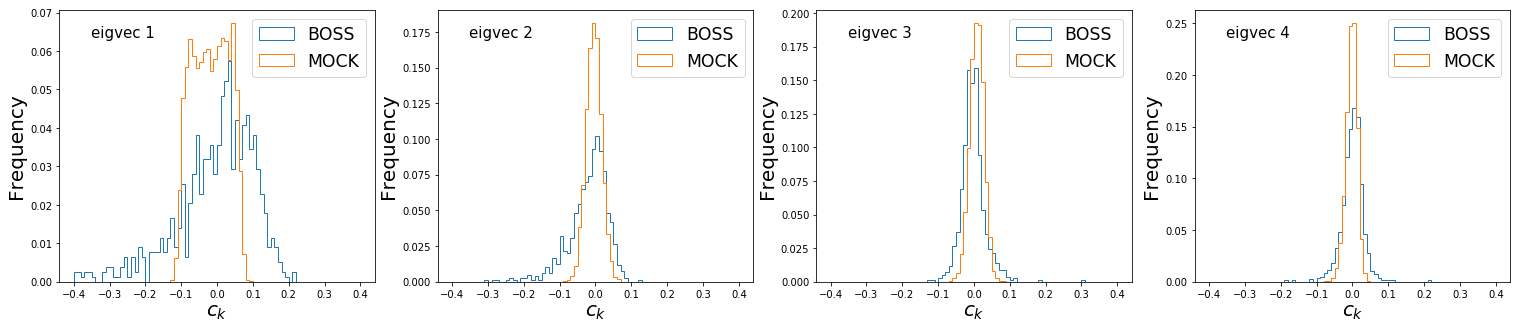

In [32]:
coeff_hist(coeff11,dcoeff11,-0.4,0.4,0.01)
#plt.savefig('coeff_11.png')

# 21.0 < MAG < 21.5 and 2.6 < z < 2.8.

In [33]:
### mock
wave22, mean22, std22, coeff22 = empca_nor_stack(MG22[1]['wavelength'].read(),MG22[4]['coeff'].read(),MG22[3]['eigenvec'].read(),MG22[1]['mean spectrum'].read())

In [34]:
### data
dwave22, dmean22, dstd22, dcoeff22 = empca_nor_stack(DS22[1]['wavelength'].read(),DS22[4]['coeff'].read(),DS22[3]['eigenvec'].read(),DS22[1]['mean spectrum'].read())

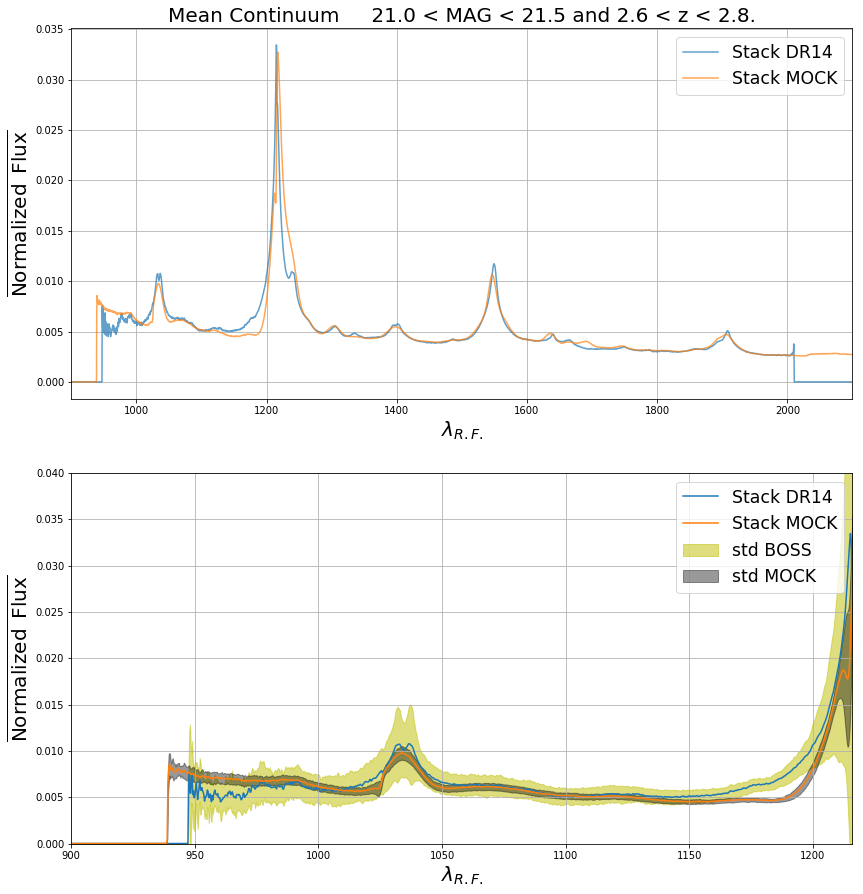

In [35]:
mean_cont(wave22,mean22,dwave22,dmean22,std22,dstd22,2.6,2.8,21.0,21.5,900,2100,900,1216)
#plt.savefig('mean_cont_22.png')

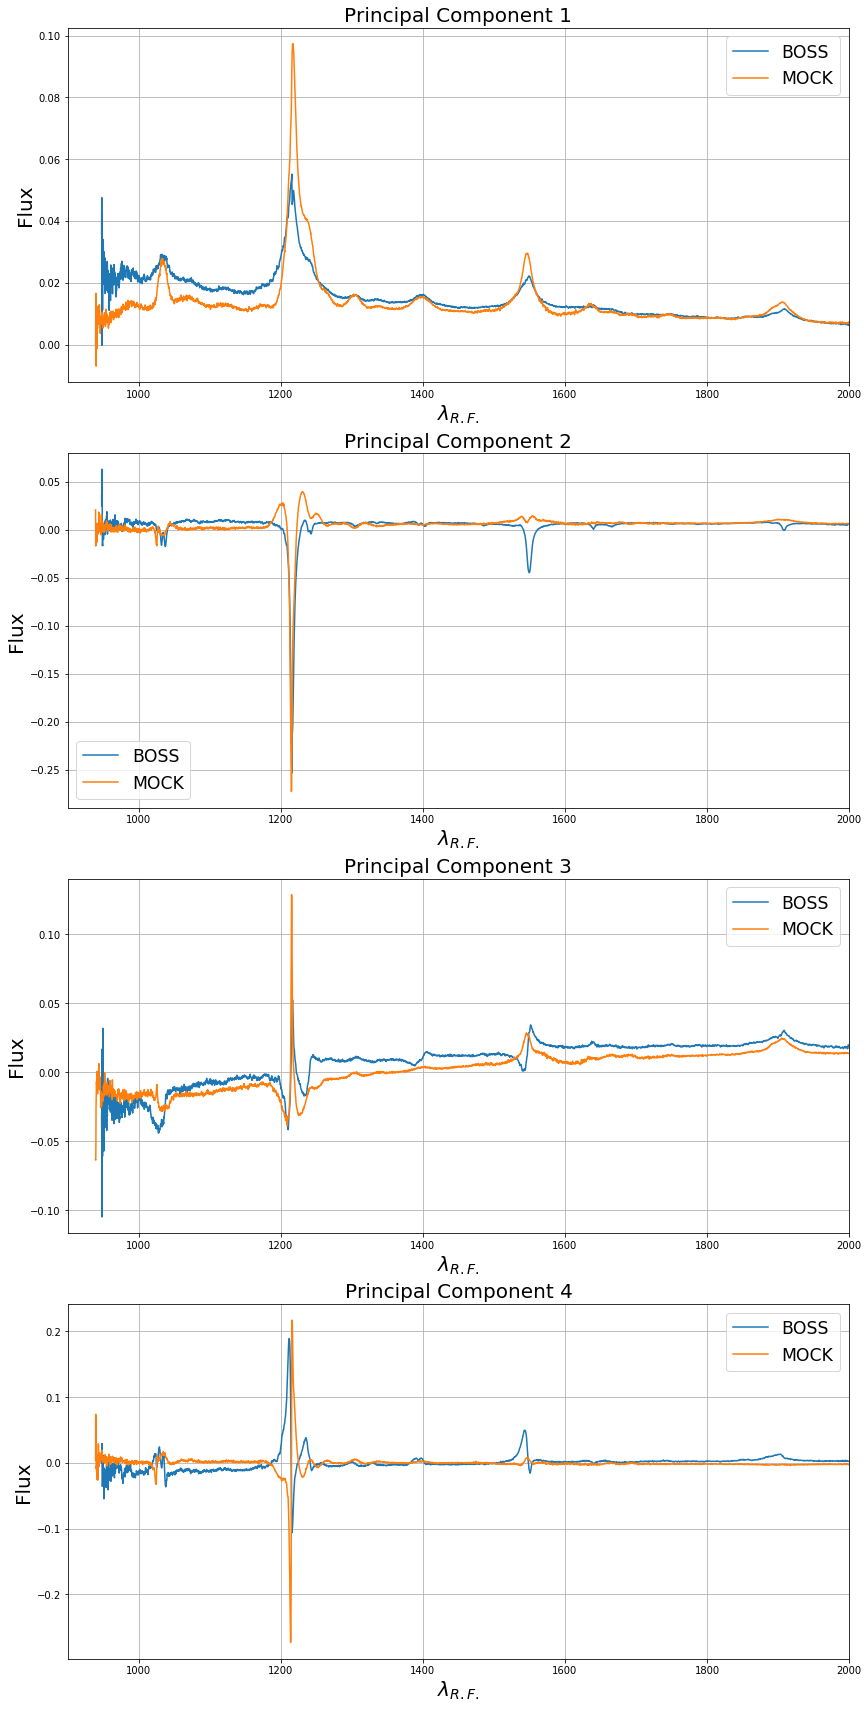

In [36]:
eigvec_plot(MG22[1]['wavelength'].read(),MG22[3]['eigenvec'].read(),DS22[1]['wavelength'].read(),DS22[3]['eigenvec'].read(),900,2000)
#plt.savefig('eigvecs_22.png')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


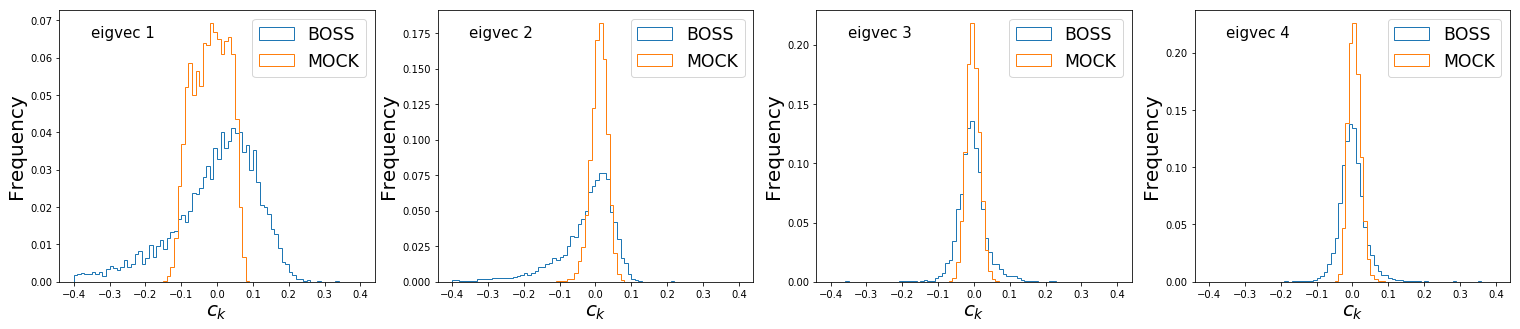

In [37]:
coeff_hist(coeff22,dcoeff22,-0.4,0.4,0.01)
#plt.savefig('coeff_22.png')

# 21.5 < MAG < 22.0 and 3.0 < z < 3.2.

In [38]:
### mocks
wave33, mean33, std33, coeff33 = empca_nor_stack(MG33[1]['wavelength'].read(),MG33[4]['coeff'].read(),MG33[3]['eigenvec'].read(),MG33[1]['mean spectrum'].read())

In [39]:
### data
dwave33, dmean33, dstd33, dcoeff33 = empca_nor_stack(DS33[1]['wavelength'].read(),DS33[4]['coeff'].read(),DS33[3]['eigenvec'].read(),DS33[1]['mean spectrum'].read())

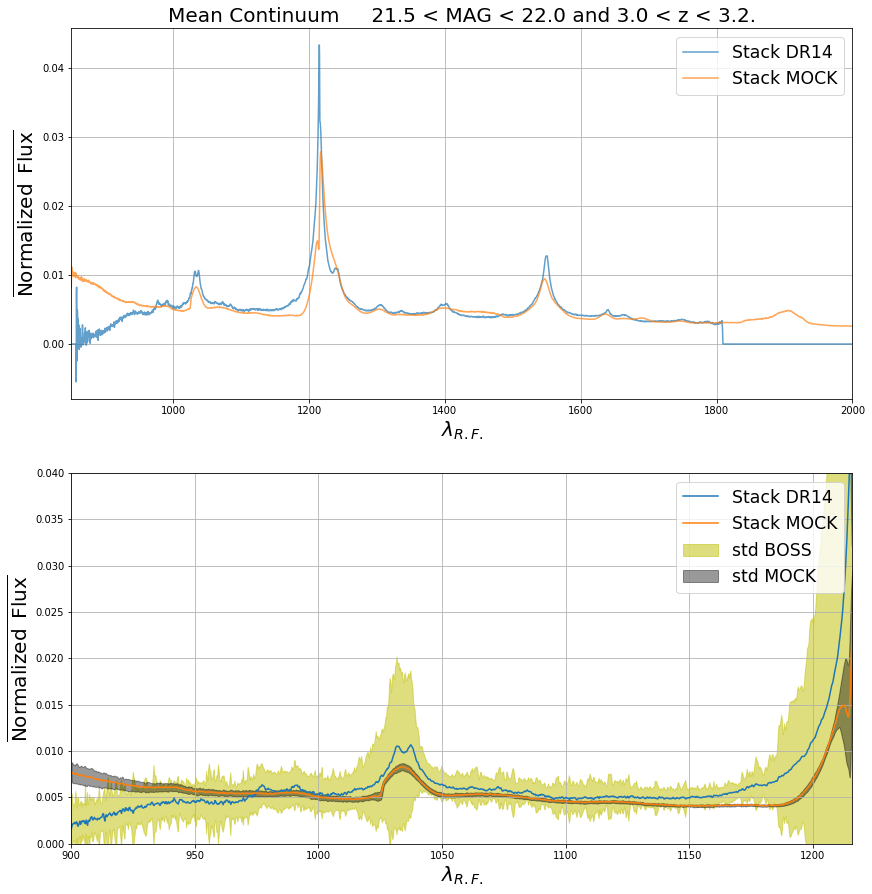

In [40]:
mean_cont(wave33,mean33,dwave33,dmean33,std33,dstd33,3.0,3.2,21.5,22.0,850,2000,900,1216)
#plt.savefig('mean_cont_33.png')

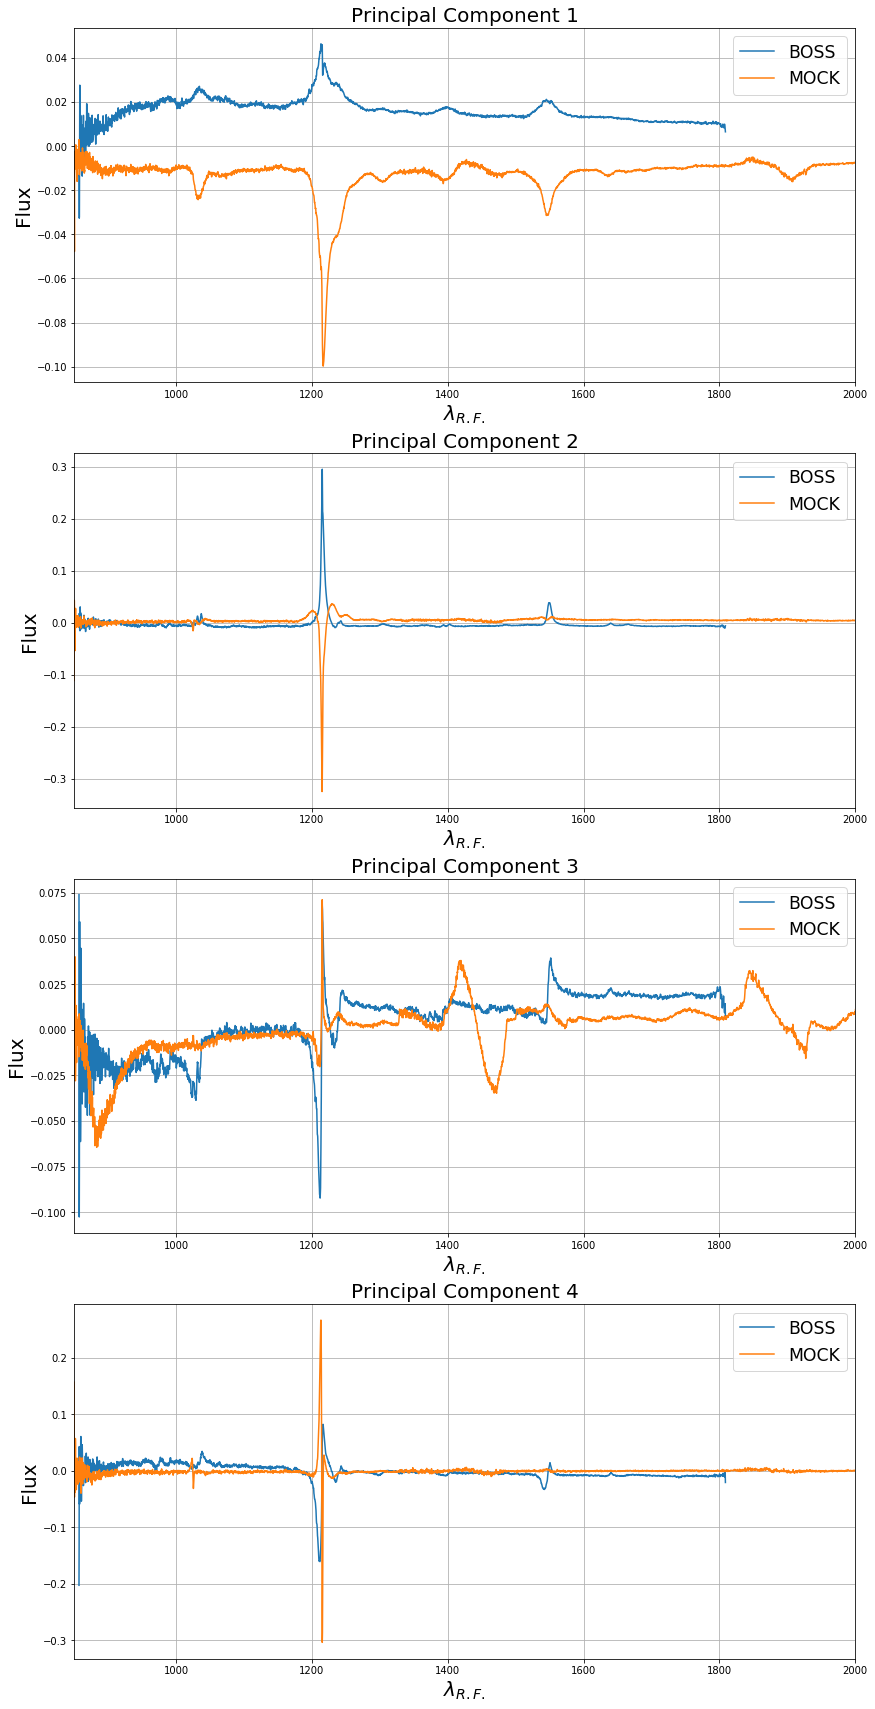

In [41]:
eigvec_plot(MG33[1]['wavelength'].read(),MG33[3]['eigenvec'].read(),DS33[1]['wavelength'].read(),DS33[3]['eigenvec'].read(),850,2000)
#plt.savefig('eigvecs_33.png')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


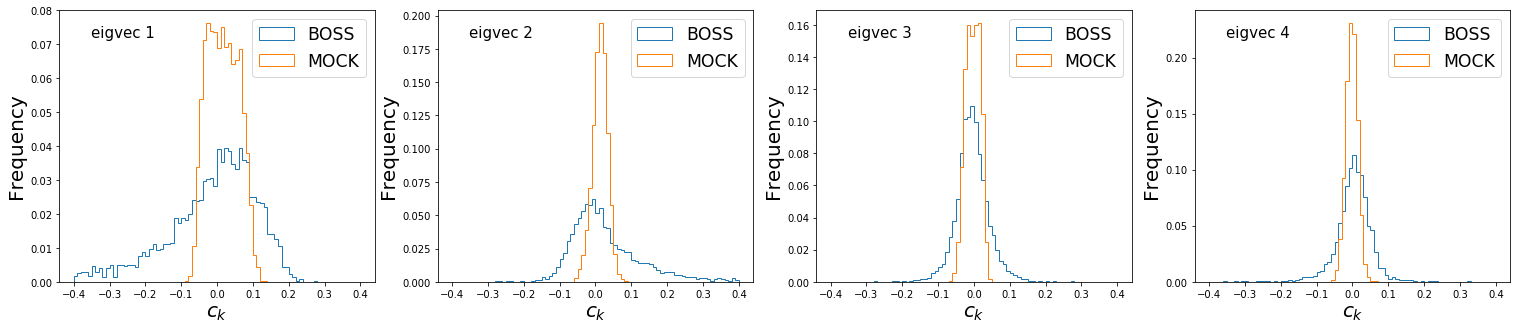

In [42]:
coeff_hist(coeff33,dcoeff33,-0.4,0.4,0.01)
#plt.savefig('coeff_33.png')

# 21.0 < MAG < 21.5 and 3.3 < z < 3.5.

In [43]:
### Mocks
wave24, mean24, std24, coeff24 = empca_nor_stack(MG24[1]['wavelength'].read(),MG24[4]['coeff'].read(),MG24[3]['eigenvec'].read(),MG24[1]['mean spectrum'].read())

In [44]:
### data
dwave24, dmean24, dstd24, dcoeff24 = empca_nor_stack(DS24[1]['wavelength'].read(),DS24[4]['coeff'].read(),DS24[3]['eigenvec'].read(),DS24[1]['mean spectrum'].read())

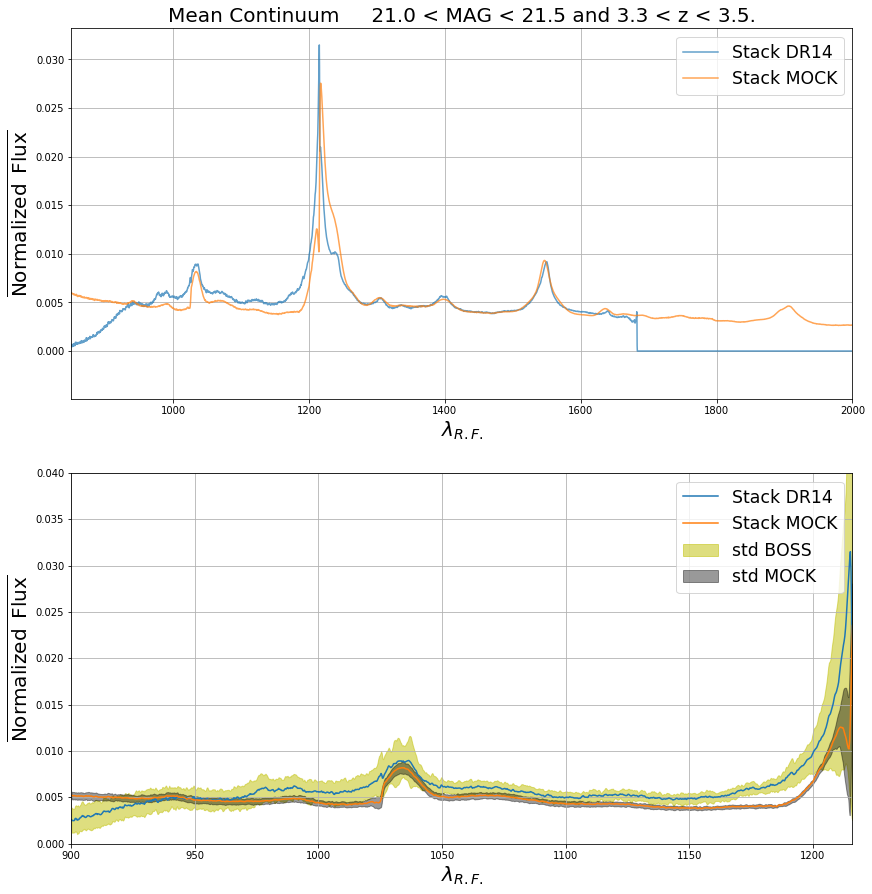

In [45]:
mean_cont(wave24,mean24,dwave24,dmean24,std24,dstd24,3.3,3.5,21.0,21.5,850,2000,900,1216)
#plt.savefig('mean_cont_24.png')

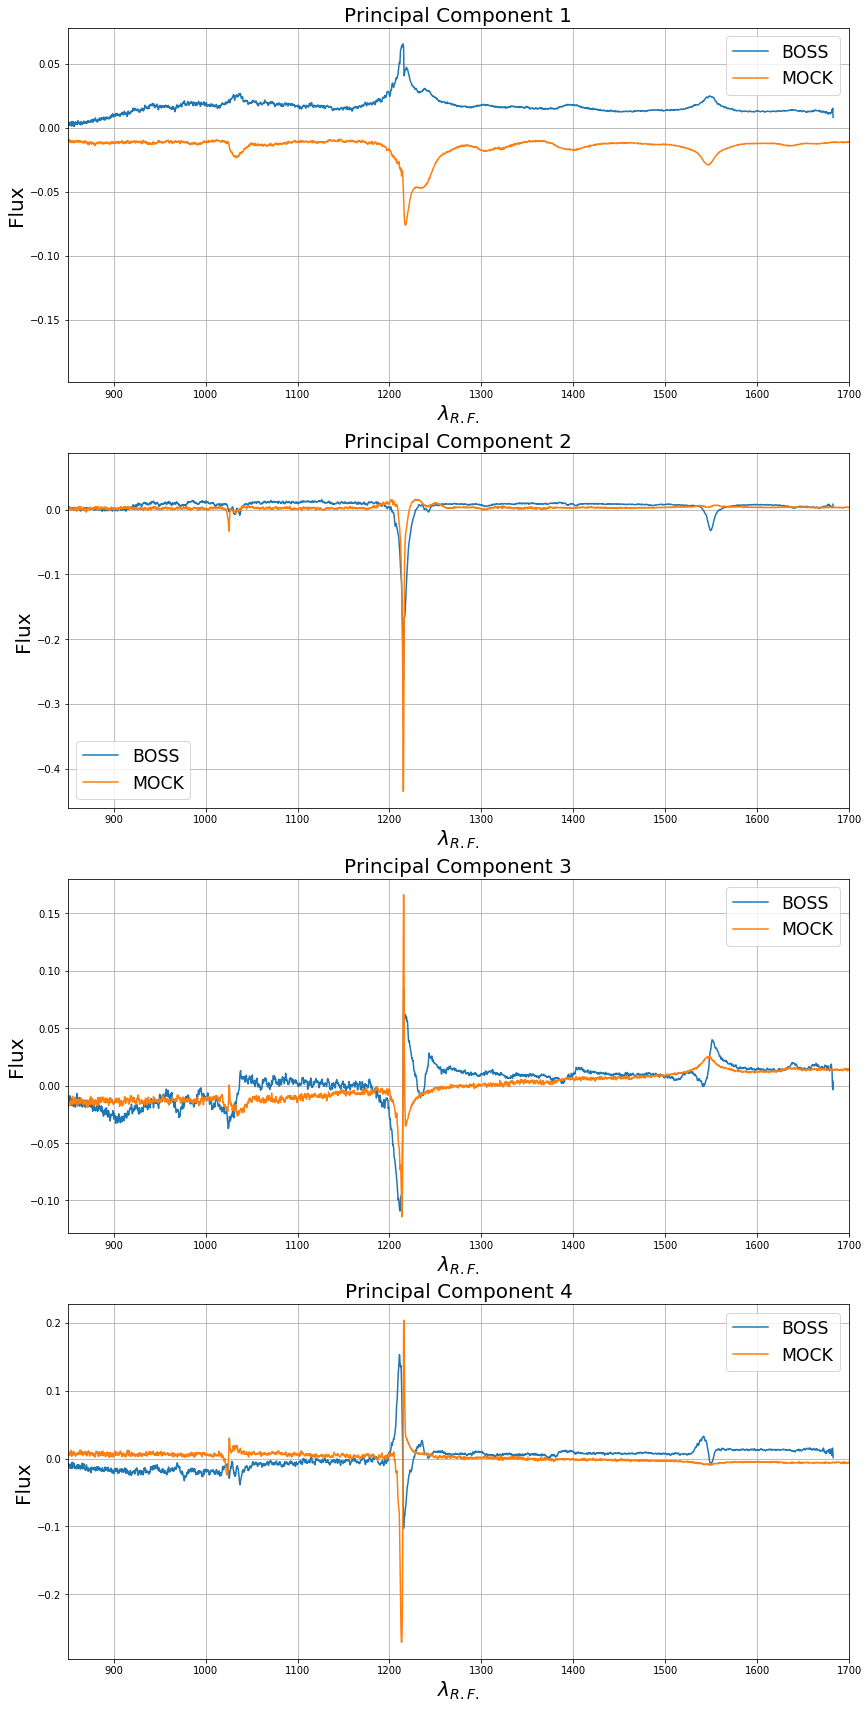

In [46]:
eigvec_plot(MG24[1]['wavelength'].read(),MG24[3]['eigenvec'].read(),DS24[1]['wavelength'].read(),DS24[3]['eigenvec'].read(),850,1700)
#plt.savefig('eigvecs_24.png')

/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


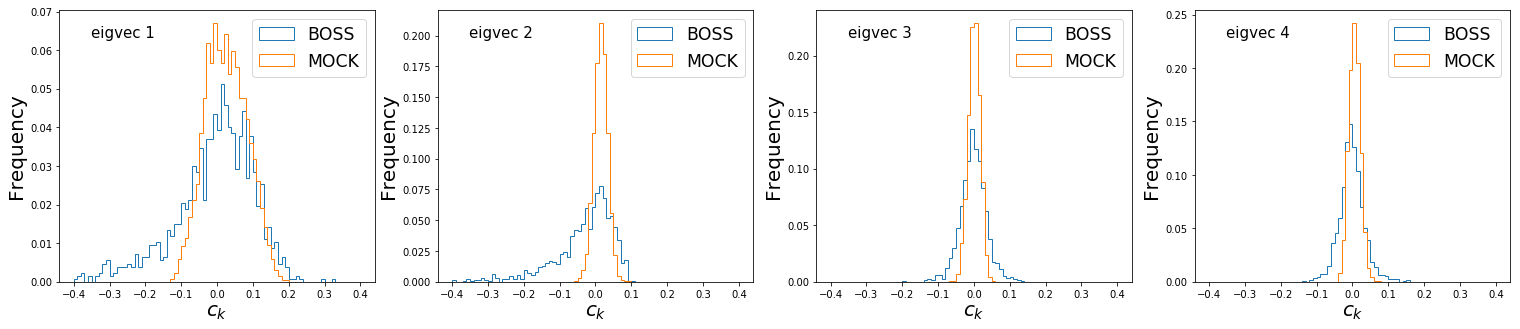

In [47]:
coeff_hist(coeff24,dcoeff24,-0.4,0.4,0.01)
#plt.savefig('coeff_24.png')

# PICCA

Let's make a comparison using PICCA, but without magnitude and redshift bins, let's take 200,000 spectra for old mocks and modified mocks, further let's get 1d and 3d autocorrelation of the Lya forest.

In [48]:
sys.path.append('/global/cscratch1/sd/rodcn25/desi/code/picca/py/')
from picca import wedgize

In [50]:
data = {}
data['path_base'] = '/global/cscratch1/sd/rodcn25/comparacion/'
### OLD MOCKS LYA
Afdir = data['path_base']+'mocks/LYA/Delta_LYA/Log/delta_attributes.fits.gz'
Acor1d = data['path_base']+'mocks/LYA/Correlations/cf1d.fits.gz'
Acor3d = data['path_base']+'mocks/LYA/Correlations/e_cf.fits.gz'
### MODIFIED MOCKS LYA
Bfdir = data['path_base']+'mocks_modificados/LYA/Delta_LYA/Log/delta_attributes.fits.gz'
Bcor1d = data['path_base']+'mocks_modificados/LYA/Correlations/cf1d.fits.gz'
Bcor3d = data['path_base']+'mocks_modificados/LYA/Correlations/e_cf.fits.gz'
###
Afm = fitsio.read(Afdir,'cont')
Bfm = fitsio.read(Bfdir,'cont')

Let's look the mean continuum from PICCA. The number of spectra used were 200,000.

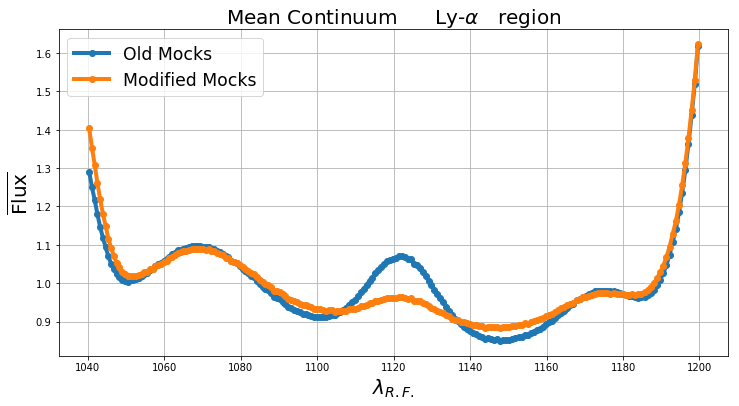

In [53]:
plt.figure(figsize=(12,6))
plt.title(r'Mean Continuum      Ly-$\alpha$   region',fontsize = 20)
plt.plot(10**Afm['loglam_rest'],Afm['mean_cont'],'o-',linewidth=4,label='Old Mocks')
plt.plot(10**Bfm['loglam_rest'],Bfm['mean_cont'],'o-',linewidth=4,label='Modified Mocks')
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

Let's look 1d auto correlation of the Lya forest

In [54]:
### Old Mock LYA
corr = fitsio.FITS(Acor1d)
head = corr[1].read_header()
dll = head['DLL']
corrd = fitsio.read(Acor1d,'1dcor')
y = corrd['c1d'][:]
bins = sp.arange(y.size)
x = sp.power(10,bins*dll)
w = corrd['nc1d'][:]>0.
x = x[w]
y = y[w]

### Modified Mock LYA
corre = fitsio.FITS(Bcor1d)
headd = corre[1].read_header()
ddll = headd['DLL']
corred = fitsio.read(Bcor1d,'1dcor')
s = corred['c1d'][:]
bbins = sp.arange(s.size)
r = sp.power(10,bbins*ddll)
v = corred['nc1d'][:]>0.
r = r[v]
s = s[v]

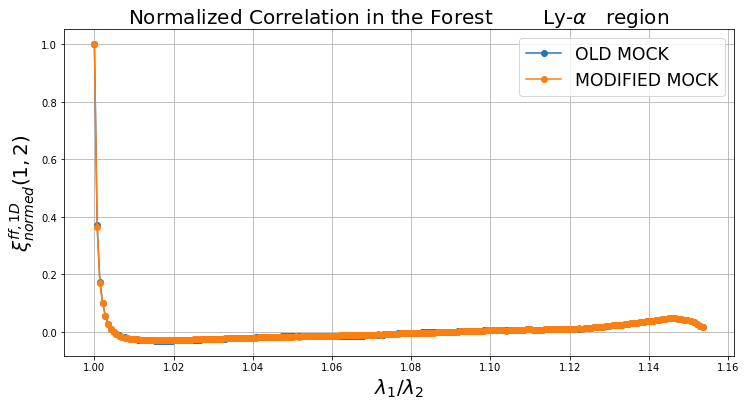

In [58]:
plt.figure(figsize=(12,6))
plt.title(r'Normalized Correlation in the Forest        Ly-$\alpha$   region',fontsize = 20)
plt.plot(x,y,'-o',label='OLD MOCK')
plt.plot(r,s,'-o',label='MODIFIED MOCK')
plt.xlabel(r'$\lambda_{1}/\lambda_{2}$',fontsize = 20)
plt.ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$',fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

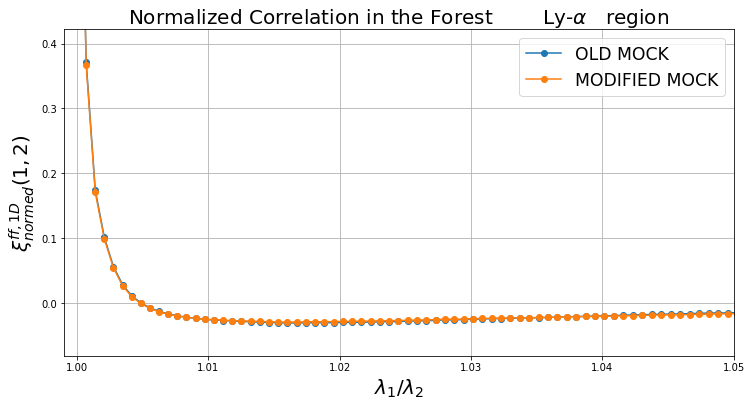

In [59]:
plt.figure(figsize=(12,6))
plt.title(r'Normalized Correlation in the Forest        Ly-$\alpha$   region',fontsize = 20)
plt.plot(x,y,'-o',label='OLD MOCK')
plt.plot(r,s,'-o',label='MODIFIED MOCK')
plt.xlabel(r'$\lambda_{1}/\lambda_{2}$',fontsize = 20)
plt.ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$',fontsize = 20)
ymin = 1.e6
ymax = -1.e6
ymin = min(ymin,y.min())
ymax = max(ymax,y[y!=1.].max())
plt.xlim([0.999,1.05])
plt.ylim([ymin-0.05,ymax+0.05])
plt.legend(fontsize='xx-large')
plt.grid()

In [65]:
def autocor(oldmock,newmock,mu_min,mu_max):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    ### Mocks
    data = fitsio.FITS(oldmock)
    da = data[1]['DA'][:]
    co = data[1]['CO'][:]
    rpmin = data[1].read_header()['RPMIN']
    np = data[1].read_header()['NP']
    mumin = mu_min
    mumax = mu_max
    w = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=rpmin,nrp=np,absoluteMu=True)
    r,d,c = w.wedge(da,co)
    plt.errorbar(r,d*r**2,yerr=sp.sqrt(c.diagonal())*r**2,fmt="o",label='Mocks')
    ### Modified Mocks
    Bdata = fitsio.FITS(newmock)
    Bda = Bdata[1]['DA'][:]
    Bco = Bdata[1]['CO'][:]
    Brpmin = Bdata[1].read_header()['RPMIN']
    Bnp = Bdata[1].read_header()['NP']
    Bw = wedgize.wedge(mumin=mumin,mumax=mumax,rpmin=Brpmin,nrp=Bnp,absoluteMu=True)
    Br,Bd,Bc = Bw.wedge(Bda,Bco)
    plt.errorbar(Br,Bd*Br**2,yerr=sp.sqrt(Bc.diagonal())*Br**2,fmt="o",label='Modified Mocks')

    plt.grid()
    plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$",fontsize=20)
    plt.ylabel(r"$r^2\xi(r) \, [\mathrm{Mpc \, h^{-1}}]$",fontsize=20)
    plt.title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.tight_layout()
    plt.legend(fontsize='xx-large')
    #########
    mask = (r>50) & (r<150)
    sigmad = sp.sqrt(c.diagonal()[mask])*r[mask]**2
    sigmam = sp.sqrt(Bc.diagonal()[mask])*Br[mask]**2
    porerr = 100*abs((sigmad-sigmam)/sigmad)
    meanpe = sp.average(porerr)
    #########
    plt.subplot(1,2,2)
    plt.plot(r[mask],porerr,'o-')
    axhline(meanpe,color='r',label='mean value = {}%'.format(meanpe))
    plt.xlabel(r"$r \, [\mathrm{Mpc \, h^{-1}}]$",fontsize=20)
    plt.ylabel(r"$|\dfrac{(\sigma_{default}-\sigma_{modified})}{\sigma_{default}}|\%$",fontsize=20)
    plt.title(r"Difference in the Correlation Function Errorbars              ${}<\mu<{}$".format(mumin,mumax),fontsize=16)
    plt.tight_layout()
    plt.legend(fontsize='xx-large')
    plt.grid()

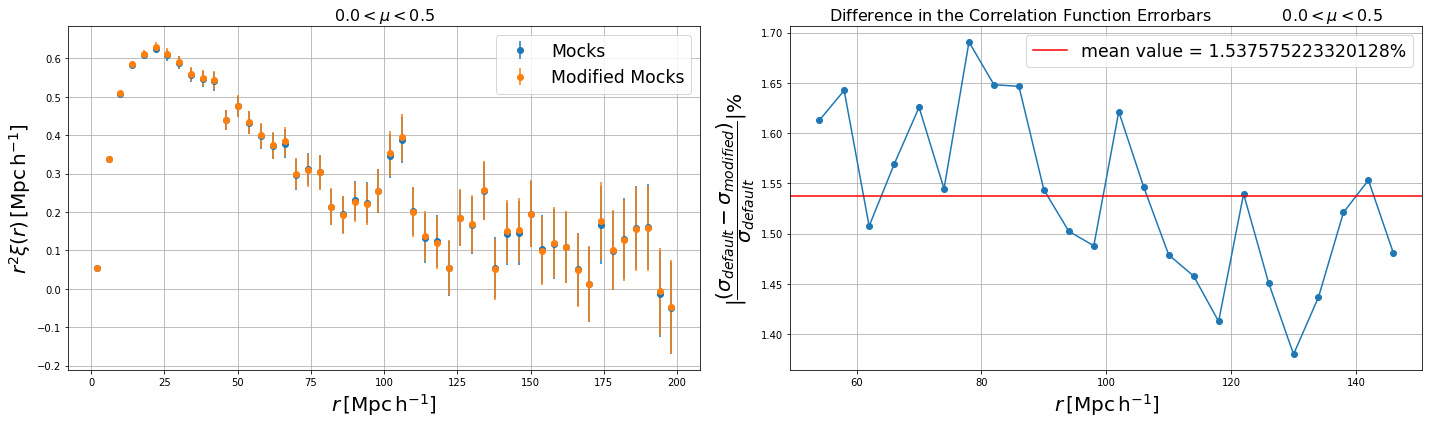

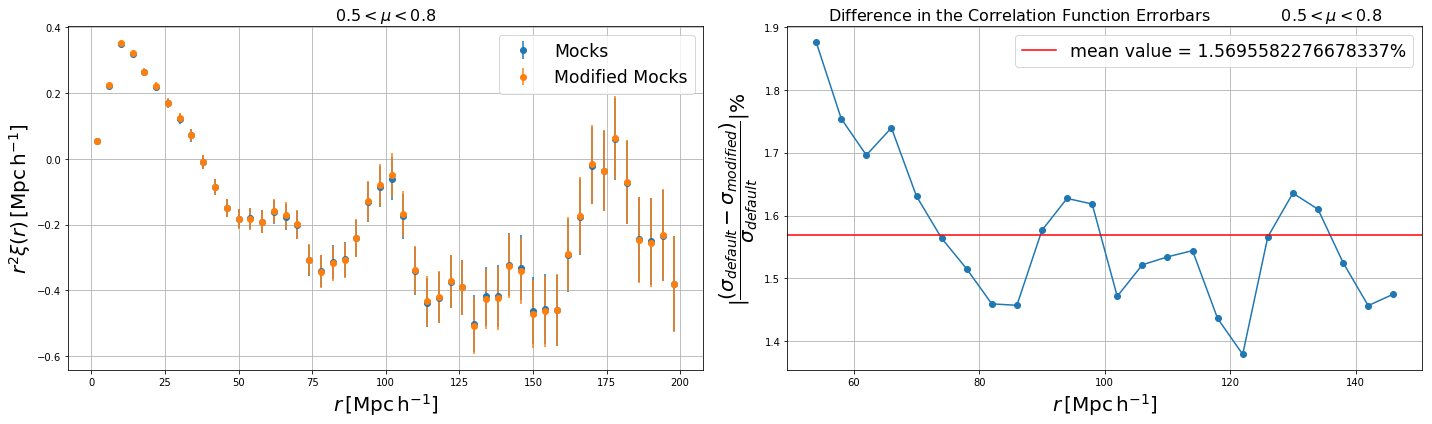

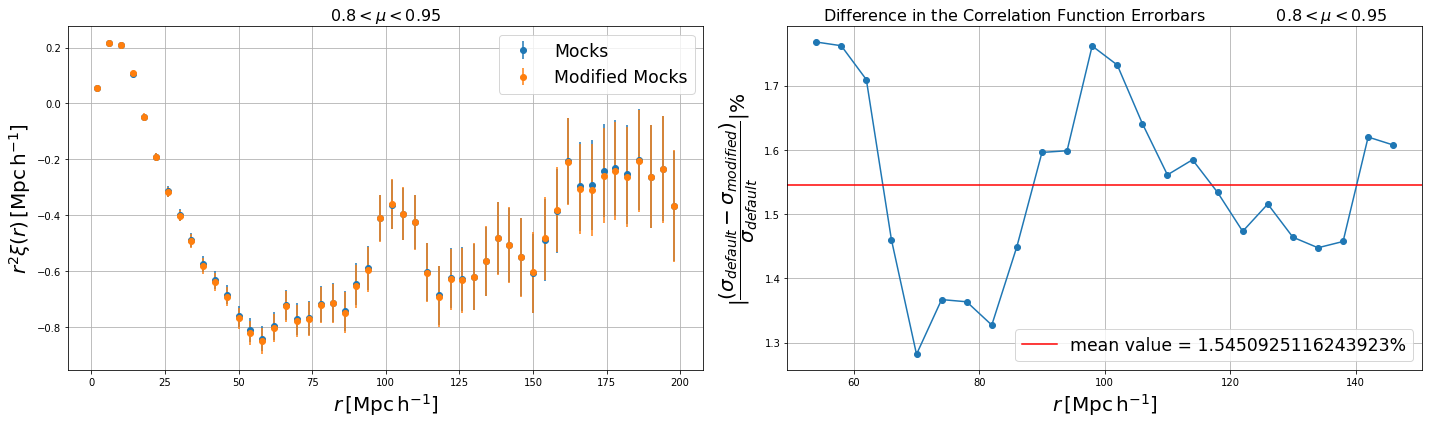

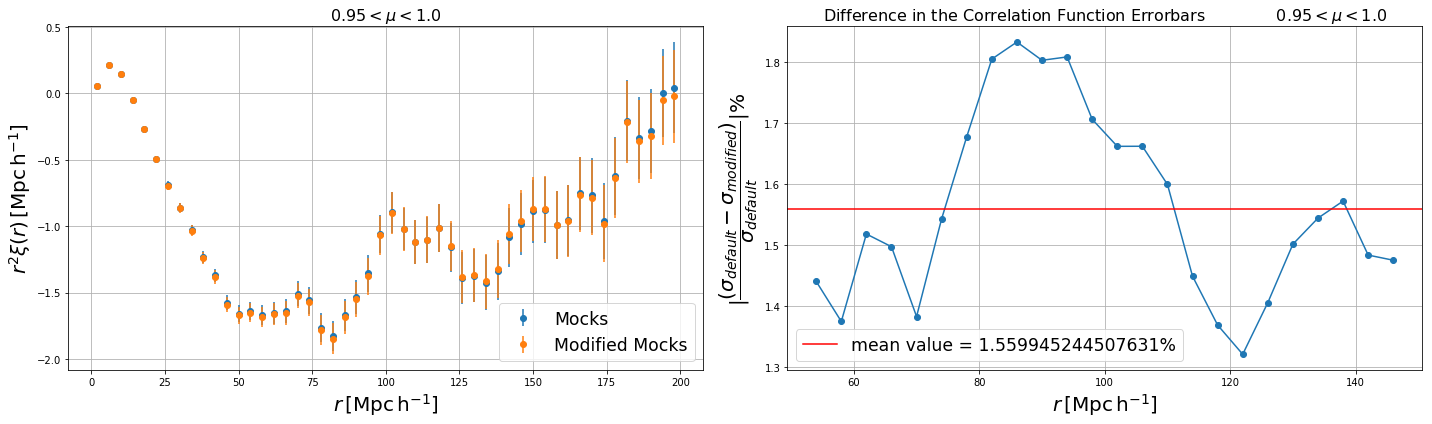

In [66]:
mus=[0., 0.5, 0.8, 0.95, 1.]
for mumin,mumax in zip(mus[:-1],mus[1:]):
    autocor(Acor3d,Bcor3d,mumin,mumax)

The change of the 3d autocorrelation of the Lya forest due to these modifications is around 1.5%